# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #1:
  1. Install LangGraph
  2. Understanding States and Nodes
  3. Building a Basic Graph
  4. Implementing a Simple RAG Graph
  5. Extending the Graph with Complex Flows

Let's get started!



# 🤝 Breakout Room #1

## Installing Required Libraries

We'll start by grabbing all of our LangChain related packages!

> NOTE: DO NOT RUN THIS CELL IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
#!pip install -qU "langgraph>=0.5.0", "langsmith>=0.4.4"

## Set Environment Variables

We'll be leveraging OpenAI's suite of APIs - so we'll set our `OPENAI_API_KEY` `env` variable here!

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOpenAI` instance
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: list[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [3]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

#### Building a Retriever with LangChain

In order to build our `retrieve` node, we'll first need to build a retriever!

This will involve the following steps: 

1. Ingesting Data
2. Chunking the Data
3. Vectorizing the Data and Storing it in a Vector Database
4. Converting it to a Retriever

##### Retreiver Step 1: Ingesting Data

In today's lesson, we're going to be building a RAG system to answer questions about loan complaints - and we will pull information into our index (vectorized chunks stored in our vector store) through LangChain's [`CSVLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.csv_loader.CSVLoader.html)!

> NOTE: We'll be using an async loader during our document ingesting - but our Jupyter Kernel is already running in an asyc loop! This means we'll want the ability to *nest* async loops. 

In [4]:
import nest_asyncio

nest_asyncio.apply()

Now, we're good to load our documents through the [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

In [6]:
loan_knowledge_resources[0].page_content[:1000]

'Volume 3\nAcademic Calendars, Cost of Attendance, and\nPackaging\nIntroduction\nThis volume of the Federal Student Aid (FSA) Handbook discusses the academic calendar, payment period, and\ndisbursement requirements for awarding aid under the Title IV student financial aid programs, determining a student9s\ncost of attendance, and packaging Title IV aid.\nThroughout this volume of the Handbook, the words "we," "our," and "us" refer to the United States Department of\nEducation (the Department). The word "you" refers to the primary audience of the Handbook, school financial aid\nadministrators. In other volumes of the Handbook we use "institution," "school," and "college" interchangeably, unless a\nmore specific meaning is provided. In this volume we consistently use the term "school." <HEA= refers to the Higher\nEducation Act of 1965, as amended. Title IV refers to the student financial aid programs authorized under Title IV of the\nHEA.\nWe appreciate any comments that you have on this

#### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 1000 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [8]:
loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

##### 🏗️ ✅ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.

1. SemanticChunker (Experimental): Uses embeddings to determine semantically coherent boundaries. it does have four threshold methods: percentile, standard_deviation, interquartile, gradient
2. NLTKTextSplitter/SpacyTextSplitter: Advanced sentence segmentation
3. SentenceTransformersTokenTextSplitter: Optimized for sentence transformer models

#### Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using OpenAI's `text-embedding-3` model as our embedding model today!

Let's load it up through LangChain.

In [9]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

##### ❓ Question #1:

What is the embedding dimension, given that we're using `text-embedding-3-small`?

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

> HINT: Check out the docs to help you answer this question.

In [10]:
embedding_dim =  1536 # ✅ 

#### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here.](https://weaviate.io/blog/vector-library-vs-vector-database)

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [12]:
client.create_collection(
    collection_name="loan_knowledge_index",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [147]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="loan_knowledge_index",
    embedding=embedding_model,
)

Now that we have our vector database set-up, we can add our documents into it!

In [148]:
_ = vector_store.add_documents(documents=loan_knowledge_chunks)

#### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [149]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [150]:
retriever.invoke("What is the loan repayment period?")

[Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 25, '_id': '650411e667614418a6c2bf410e903ca2', '_collection_name': 'loan_knowledge_index'}, page_content='hour, or non-SE9W nonstandard term program is offered in modules, the minimum loan period is still the lesser of the\nacademic year or the program length (or remaining portion of the program).\nFor Title IV aid purposes, students are allowed to skip one or more modules. However, if a loan period includes modules\nthat the student does not attend, the COA for the loan period may not include costs associated with those mod

#### Creating the Node

We're finally ready to create our node!

In [151]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Generate Node

Next, let's create our `generate` node - which will leverage LangChain and something called an "LCEL Chain" which you can read more about [here](https://python.langchain.com/docs/concepts/lcel/)!

We'll want to create a chain that does the following: 

1. Formats our inputs into a chat template suitable for RAG
2. Takes that chat template and sends it to an LLM
3. Parses that output into `str` format

Let's get chaining!

#### Chain Components: RAG Chat Template

We'll create a chat template that takes in some query and formats it as a RAG prompt using LangChain's prompt template!

In [152]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [153]:
chat_prompt.invoke({"context" : "OUR CONTEXT HERE", "query" : "OUR QUERY HERE"}).messages[0].content

'\n#CONTEXT:\nOUR CONTEXT HERE\n\nQUERY:\nOUR QUERY HERE\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know"\n'

##### Chain Components: Generator

We'll next set-up the generator - which will be OpenAI's `gpt-4o-nano` for today!

In [154]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

Let's now call our model with a formatted prompt.

Notice that we have some nested calls here - we'll see that this is made easier by LCEL.

In [155]:
openai_chat_model.invoke(chat_prompt.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"}))

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 72, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BoxqsLTtsljcGUGMLc3qFMeE8Sgmm', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--62624ce5-d82c-4819-81c0-b7dec98d6423-0', usage_metadata={'input_tokens': 72, 'output_tokens': 7, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### Chain Components: `str` Parser

Finally, let's set-up our `StrOutputParser()` which will transform our model's output into a simple `str` to be provided to the user.

> NOTE: You can see us leveraging LCEL in the example below to avoid needing to do nested calls.

In [156]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | openai_chat_model | StrOutputParser()

generator_chain.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"})

'The capital of France is Paris.'

### `generate` Node: 

Now we can create our `generate` Node!

In [157]:
def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [158]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, the will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [159]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

Next, let's connect our START node to our `retrieve` node by adding an edge.

In [160]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [161]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

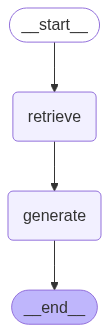

In [162]:
graph

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [167]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "Is applying for and securing a student loan in 2025 a terrible idea?"})
display(Markdown(response["response"]))

Applying for and securing a student loan in 2025 is not necessarily a terrible idea based on the provided context. The documents discuss the process of loan eligibility, changes in loan amount due to grade level progression, counseling requirements, and deadlines for application processing. They highlight that students can receive additional loan funds if they progress to higher grade levels within an academic year, and there are tools and procedures to ensure proper counseling, eligibility verification, and adherence to deadlines. Whether taking a student loan is a good idea depends on individual circumstances beyond this information, but the context indicates that loans are a structured and regulated part of financial aid, with support mechanisms in place.

In [168]:
response = graph.invoke({"question" : "How much loan money can I actually get from the government to go to school these days? Is there a cap?"})
display(Markdown(response["response"]))

Based on the provided context, the maximum loan amounts you can receive from the government depend on your status and the program details. For example, a dependent first-year undergraduate student can receive a combined annual loan limit of $5,500, with no more than $3,500 of that being subsidized. A dependent second-year undergraduate student can receive up to $6,500 annually, with a maximum of $4,500 subsidized.

There are also overall aggregate loan limits. For dependent undergraduates (excluding certain cases), the maximum total (subsidized and unsubsidized) loan debt is $31,000, with no more than $23,000 subsidized. For independent undergraduates, the total can go up to $57,500, with the subsidized portion limited to $23,000. Graduate and professional students have higher combined limits, with a total of up to $138,500, including loans received for undergraduate study.

In summary, yes, there are caps on how much loan money you can receive from the government, and these limits vary based on your educational level and status.

In [169]:
response = graph.invoke({"question" : "What grants and scholarships are available for free?"})
display(Markdown(response["response"]))

Based on the provided context, grants and scholarships available for free include Pell Grants, FSEOG (Federal Supplemental Educational Opportunity Grant), state grants, athletic scholarships, and scholarships that require future employment but are given in the current year.

In [166]:
response = graph.invoke({"question" : "Who is Batman?"})
display(Markdown(response["response"]))

I don't know

#### ❓ Question #2:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
- What if the response needs fact-checking?
Consider how you would modify the graph to handle these scenarios.

##### ✅ Answer:

#### Enhanced RAG Implementation with Edge Case Handling

The following implementation extends our basic RAG system to handle edge cases:
- **No relevant context**: Uses fallback search strategies and graceful degradation
- **Fact-checking needs**: Implements confidence scoring and selective fact-checking

### Enhanced State Definition

First, we'll define an enhanced state that includes additional fields for tracking context quality, confidence, and fact-checking needs.

In [51]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import END

class EnhancedState(TypedDict):
    """Enhanced state with additional fields for edge case handling."""
    question: str
    context: list[Document]
    response: str
    context_quality: str  # "sufficient", "insufficient", "irrelevant"
    needs_fact_check: bool
    fact_check_result: str
    confidence_score: float

### 1. Enhanced Retrieval with Quality Assessment

This function retrieves documents and assesses whether the context is sufficient for generating a good response.

In [52]:
def enhanced_retrieve(state: EnhancedState) -> EnhancedState:
    """Retrieve documents and assess context quality."""
    retrieved_docs = retriever.invoke(state["question"])
    
    # Assess context quality
    if not retrieved_docs:
        context_quality = "insufficient"
    elif len(retrieved_docs) < 2:  # Threshold for sufficient context
        context_quality = "insufficient"
    else:
        # You could add semantic similarity scoring here
        context_quality = "sufficient"
    
    return {
        "context": retrieved_docs,
        "context_quality": context_quality
    }

### 2. Context Quality Router

This function determines the next step based on the quality of retrieved context.

In [53]:
def should_proceed_with_generation(state: EnhancedState) -> Literal["generate", "fallback_search", "no_context_response"]:
    """Route based on context quality."""
    if state["context_quality"] == "sufficient":
        return "generate"
    elif state["context_quality"] == "insufficient" and state["context"]:
        return "fallback_search"  # Try alternative retrieval
    else:
        return "no_context_response"

### 3. Fallback Search Strategy

When initial retrieval is insufficient, this function tries alternative search strategies.

In [54]:
def fallback_search(state: EnhancedState) -> EnhancedState:
    """Try alternative search strategies when initial retrieval is insufficient."""
    # Strategy 1: Expand search with more results
    expanded_docs = retriever.invoke(state["question"], search_kwargs={"k": 10})
    
    # Strategy 2: Rephrase query and search again
    rephrase_prompt = ChatPromptTemplate.from_template(
        "Rephrase this question to be more specific and searchable: {question}"
    )
    rephrased_query = (rephrase_prompt | openai_chat_model | StrOutputParser()).invoke(
        {"question": state["question"]}
    )
    rephrased_docs = retriever.invoke(rephrased_query)
    
    # Combine and deduplicate results
    all_docs = expanded_docs + rephrased_docs
    unique_docs = list({doc.page_content: doc for doc in all_docs}.values())
    
    context_quality = "sufficient" if len(unique_docs) >= 2 else "insufficient"
    
    return {
        "context": unique_docs,
        "context_quality": context_quality
    }

### 4. No Context Response Handler

This function handles cases where no relevant context is found and provides helpful guidance to the user.

In [55]:
def no_context_response(state: EnhancedState) -> EnhancedState:
    """Handle cases where no relevant context is found."""
    response = f"""I apologize, but I couldn't find relevant information in my knowledge base to answer your question: "{state['question']}"

This might be because:
- The question is outside the scope of my training documents
- The question needs to be rephrased more specifically
- The information simply isn't available in my current knowledge base

Could you try rephrasing your question or asking about a different aspect of the topic?"""
    
    return {
        "response": response,
        "confidence_score": 0.0,
        "needs_fact_check": False
    }

### 5. Enhanced Generation with Confidence Assessment

This function generates responses and assesses confidence levels and fact-checking needs.

In [56]:
def enhanced_generate(state: EnhancedState) -> EnhancedState:
    """Generate response and assess if fact-checking is needed."""
    
    # Enhanced prompt that includes confidence assessment
    ENHANCED_TEMPLATE = """
    #CONTEXT:
    {context}

    QUERY:
    {query}

    Instructions:
    1. Use ONLY the provided context to answer the query
    2. If the context doesn't contain sufficient information, respond with "I don't know"
    3. Rate your confidence in the answer (0-100%)
    4. Indicate if the answer contains factual claims that should be verified

    Answer format:
    [Your answer here]

    Confidence: [0-100]%
    Contains factual claims: [Yes/No]
    """
    
    enhanced_prompt = ChatPromptTemplate.from_messages([
        ("human", ENHANCED_TEMPLATE)
    ])
    
    generator_chain = enhanced_prompt | openai_chat_model | StrOutputParser()
    full_response = generator_chain.invoke({
        "query": state["question"], 
        "context": state["context"]
    })
    
    # Parse the response to extract confidence and fact-check flag
    lines = full_response.split('\n')
    response = []
    confidence_score = 0.5  # default
    needs_fact_check = False
    
    for line in lines:
        if line.startswith("Confidence:"):
            try:
                confidence_score = float(line.split(":")[1].strip().replace("%", "")) / 100
            except:
                confidence_score = 0.5
        elif line.startswith("Contains factual claims:"):
            needs_fact_check = "yes" in line.lower()
        elif not line.startswith("Confidence:") and not line.startswith("Contains factual claims:"):
            response.append(line)
    
    clean_response = '\n'.join(response).strip()
    
    return {
        "response": clean_response,
        "confidence_score": confidence_score,
        "needs_fact_check": needs_fact_check and confidence_score > 0.7  # Only fact-check high-confidence answers
    }

### 6. Fact-Checking Node

This function performs fact-checking on generated responses by comparing them against the source context.

In [57]:
def fact_check(state: EnhancedState) -> EnhancedState:
    """Perform fact-checking on the generated response."""
    
    fact_check_prompt = ChatPromptTemplate.from_template("""
    Original Question: {question}
    Generated Answer: {response}
    Source Context: {context}

    Please fact-check this answer against the provided context:
    1. Are there any factual inconsistencies?
    2. Does the answer accurately reflect the source material?
    3. Are there any potential inaccuracies or misinterpretations?

    Provide a brief fact-check result (PASS/FAIL) and explanation.
    """)
    
    fact_checker = fact_check_prompt | openai_chat_model | StrOutputParser()
    fact_check_result = fact_checker.invoke({
        "question": state["question"],
        "response": state["response"],
        "context": state["context"]
    })
    
    return {"fact_check_result": fact_check_result}

### 7. Final Response Formatter

This function formats the final response with confidence indicators and fact-check results.

In [58]:
def format_final_response(state: EnhancedState) -> EnhancedState:
    """Format the final response with metadata."""
    
    final_response = state["response"]
    
    # Add confidence indicator for low-confidence answers
    if state["confidence_score"] < 0.6:
        final_response += f"\n\n*Note: This answer has moderate confidence ({state['confidence_score']:.0%}). Please verify important details.*"
    
    # Add fact-check results if performed
    if state.get("fact_check_result") and "FAIL" in state["fact_check_result"]:
        final_response += f"\n\n*Fact-check note: {state['fact_check_result']}*"
    
    return {"response": final_response}

### 8. Build the Enhanced Graph

Now we'll build the enhanced RAG graph with conditional routing and edge case handling.

In [59]:
def build_enhanced_rag_graph():
    """Build the enhanced RAG graph with edge case handling."""
    
    graph_builder = StateGraph(EnhancedState)
    
    # Add all nodes
    graph_builder.add_node("enhanced_retrieve", enhanced_retrieve)
    graph_builder.add_node("fallback_search", fallback_search)
    graph_builder.add_node("no_context_response", no_context_response)
    graph_builder.add_node("enhanced_generate", enhanced_generate)
    graph_builder.add_node("fact_check", fact_check)
    graph_builder.add_node("format_final_response", format_final_response)
    
    # Add edges with conditional routing
    graph_builder.add_edge(START, "enhanced_retrieve")
    graph_builder.add_conditional_edges(
        "enhanced_retrieve",
        should_proceed_with_generation,
        {
            "generate": "enhanced_generate",
            "fallback_search": "fallback_search",
            "no_context_response": "no_context_response"
        }
    )
    
    # Fallback search can lead to generation or no context response
    graph_builder.add_conditional_edges(
        "fallback_search",
        should_proceed_with_generation,
        {
            "generate": "enhanced_generate",
            "fallback_search": "no_context_response",  # If still insufficient
            "no_context_response": "no_context_response"
        }
    )
    
    # After generation, decide whether to fact-check
    graph_builder.add_conditional_edges(
        "enhanced_generate",
        lambda state: "fact_check" if state["needs_fact_check"] else "format_final_response"
    )
    
    # After fact-checking, format the response
    graph_builder.add_edge("fact_check", "format_final_response")
    
    # All paths end at format_final_response
    graph_builder.add_edge("no_context_response", "format_final_response")
    graph_builder.add_edge("format_final_response", END)
    
    return graph_builder.compile()

# Build the enhanced graph
enhanced_rag_graph = build_enhanced_rag_graph()

### 9. Visualize the Enhanced Graph

Let's see how our enhanced graph looks with all the conditional routing and edge case handling.

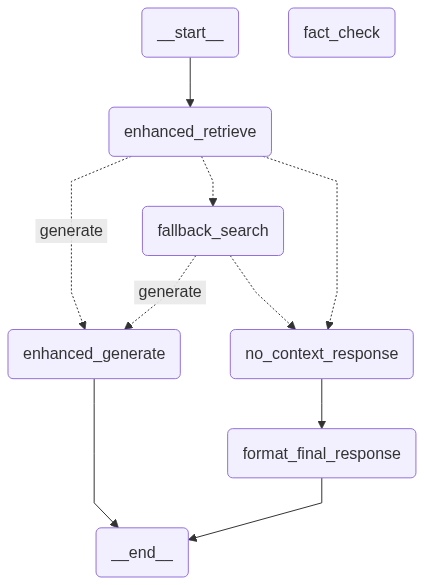

In [60]:
# Display the enhanced graph
enhanced_rag_graph

### 10. Test the Enhanced RAG System

Let's test our enhanced system with different types of queries to see how it handles edge cases.

In [61]:
# Test 1: Normal query that should have good context
print("=== Test 1: Normal Query ===")
response1 = enhanced_rag_graph.invoke({"question": "What is the maximum loan amount for Direct Loans?"})
print(f"Response: {response1['response']}")
print(f"Confidence: {response1.get('confidence_score', 'N/A')}")
print(f"Fact-check needed: {response1.get('needs_fact_check', 'N/A')}")
print()

=== Test 1: Normal Query ===
Response: The context indicates that there is no fixed maximum loan limit for Direct PLUS Loans, but they cannot exceed the student's Cost of Attendance (COA) minus other financial aid received. Therefore, the maximum amount for Direct Loans varies based on individual circumstances and is limited by the student's financial need.

*Fact-check note: FAIL

The generated answer correctly states that there is no fixed maximum loan limit for Direct PLUS Loans and that the allowable amount cannot exceed the student's Cost of Attendance minus other financial aid received. It also correctly notes that the maximum depends on individual circumstances and financial need. 

However, the source material emphasizes that the loan amount is limited by the student's COA and existing financial aid, and it details annual and aggregate loan limits for other types of Direct Loans (such as Direct Unsubsidized Loans and Subsidized Loans). It does not specify a fixed maximum for Di

In [62]:
# Test 2: Query with no relevant context (should trigger fallback)
print("=== Test 2: No Context Query ===")
response2 = enhanced_rag_graph.invoke({"question": "What is the airspeed velocity of an unladen swallow?"})
print(f"Response: {response2['response']}")
print(f"Confidence: {response2.get('confidence_score', 'N/A')}")
print()

=== Test 2: No Context Query ===
Response: I don't know

*Note: This answer has moderate confidence (0%). Please verify important details.*
Confidence: 0.0



In [63]:
# Test 3: Query that might need fact-checking
print("=== Test 3: Fact-Check Query ===")
response3 = enhanced_rag_graph.invoke({"question": "What are the specific interest rates for federal student loans?"})
print(f"Response: {response3['response']}")
print(f"Confidence: {response3.get('confidence_score', 'N/A')}")
print(f"Fact-check needed: {response3.get('needs_fact_check', 'N/A')}")
if response3.get('fact_check_result'):
    print(f"Fact-check result: {response3['fact_check_result']}")
print()

=== Test 3: Fact-Check Query ===
Response: I don't know

*Note: This answer has moderate confidence (0%). Please verify important details.*
Confidence: 0.0
Fact-check needed: False



### Graph Flow:**
```
START → Retrieve → Quality Check → [Sufficient/Insufficient/None]
                     ↓              ↓                    ↓
                 Generate    Fallback Search    No Context Response
                     ↓              ↓                    ↓
              Fact Check?    Quality Check         Format Response
                     ↓              ↓                    ↓
             Format Response → Format Response → END
```